In [ ]:
# def count_pixel_value(i, j):
# #     https://ksopyla.com/python/operacja-splotu-przetwarzanie-obrazow/
#     A = np.array([[-2, -1, 0], [-1,1,1], [0,1,2]]).ravel()
#     image_part = image[i-1:i+2, j-1:j+2].ravel() 
#     pixel_value = sum(A*image_part)/9

#     return pixel_value

# def convolve(image, size):
#     height, width = image.shape
#     # zakresy dobrane tak, aby obrabiany każdy piksel miał sąsiadów dookoła 
#     for i in range(1, height-1): 
#         for j in range(1, width-1):
#             image[i, j] = count_pixel_value(i,j)
#     return image

In [1]:
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import rescale
from matplotlib import pyplot as plt
from bresenham import bresenham
import warnings
import pydicom
import numpy as np
from math import floor, ceil, sqrt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import IPython
import sys
import tempfile
from pydicom.dataset import Dataset, FileDataset
from sklearn.metrics import mean_squared_error
%matplotlib inline

def count_neighbors_mean(image, neighbors):
    sum = 0
    for c in neighbors:
        sum += image[c[0], c[1]]
    return sum/len(neighbors)

def get_neighbors(height, width, i, j, size):
    neighbors = []
    for k in range(i-size, i+1+size):
        for l in range(j-size, j+1+size):
            if (k>=0 and l>=0 and k<height and l<width):
                neighbors.append((k,l))
    return neighbors

def convolve(image, size):
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            image[i, j] = count_neighbors_mean(image, get_neighbors(height, width, i, j, size))
    return image

def reverse_radon(
        sinogram, pixels_lines_count, emitters, 
        detectors, screenshots, stepwise, 
        convolution, image_original):
    print("Processing sinogram to image...")
    detectors_count = sinogram.shape[0]
    steps = sinogram.shape[1]
    height = pixels_lines_count.shape[0]
    width = pixels_lines_count.shape[1]
    image = np.zeros(( height, width ))
    
    #użyteczne, gdy wyświetlamy też kroki pośrednie
    shots = range(steps-1, 1, -floor(steps/(screenshots)))
    mse_array = []
    
    for i in range( steps ):
        for j in range(detectors_count):
            coordinates = list(bresenham(emitters[i][0], emitters[i][1], detectors[i][j][0], detectors[i][j][1]))
            for c in coordinates:
                if c[0] < height and c[1] < width and c[0] >= 0 and c[1] >= 0: 
                    image[c[0]][c[1]] += sinogram[j][i] / pixels_lines_count[c[0]][c[1]]
        if(stepwise):
            if(i in shots):
#                 print("MSE of transformation: "+repr(mean_squared_error(image_original, image)))
                mse_array.append(mean_squared_error(image_original, image))
                plt.imshow(image, 'gray')
                plt.show()
    if (not stepwise):
        plt.imshow(image, 'gray')
        plt.show()
        
    mse = mean_squared_error(image_original, image)
    if(convolution):
        print("Processing convolution...")
        image = convolve(image, 1) #drugi argument od convolve to rozmiar macierzy splotu
        plt.imshow(image, 'gray')
        plt.show()
        print("MSE of transformation with convolution: "+repr(mean_squared_error(image_original, image)))
    
    plt.imsave('pictures/image_out.jpg', image, cmap='gray')
    print("MSE of transformation without convolution: "+repr(mse))
    
    if(stepwise and len(mse_array)>=2):
        plt.plot(range(len(mse_array)), mse_array)
        plt.show()

def degrees_to_radians(alpha, arc):
    return np.deg2rad(alpha), np.deg2rad(arc)
    
def count_image_parameters(image, radius_scale):
    height = image.shape[0]
    width = image.shape[1]
    center = ( floor(height/2), floor( width/2 ))
    radius = radius_scale * ceil( sqrt(height**2 + width**2) / 2 )
    pixels_lines_count = np.zeros(( height, width ))
    return height, width, center, radius, pixels_lines_count

#chwilowo nieużywana - ładujemy pliki DICOM
def load_image(path, image_scale):
    image = rgb2gray(io.imread(path, multichanel = False))
    image = rescale(image, image_scale, anti_aliasing=False, mode='constant')
    print("Image to process:")
    plt.imshow(image, 'gray')
    plt.show()
    return(image)

def prepare_output():
    warnings.filterwarnings('ignore')
    return
  
def print_patient_data(dicom):
    print("Name: "+dicom.PatientName)
        
    print("Patient ID: "+dicom.PatientID)
    print("Study date: "+dicom.StudyDate)
    print(dicom.ImageComments)
    
def load_dicom(dicom, image_scale):
    try:
        ds = pydicom.dcmread(dicom)
        image = rescale(rgb2gray(ds.pixel_array), image_scale, anti_aliasing=False, mode='constant')
        print("Image to process:")
        plt.imshow(image, 'gray')
        plt.show()
        return image
    except OSError:
        sys.exit("Cannot open the file")
    
# stepwise określa, czy wyświetlamy pośrednie sinogramy/ obrazy z odtworzenia
# screenshots określa ile tych pośrednich obrazów będzie
# radius_scale mówi o ile wydłużamy promień wodzący
def radon(alpha, arc, detectors_count, radius_scale, image_scale, stepwise, screenshots, dicom, convolution):
    prepare_output()
#     image = load_dicom(dicom, image_scale)
    image = load_image('pictures/kropka.jpg', image_scale)
    height, width, center,  radius, pixels_lines_count = count_image_parameters(image, radius_scale)
    alpha, arc = degrees_to_radians(alpha, arc)
    steps = int( np.pi*2 / alpha)
    sinogram = np.zeros((detectors_count, steps))
    #współrzędne emitera i zestawu detektorów są zapisywane i wykorzystywane później przy odtwarzaniu
    #oryginalnego obrazu z sinogramu
    emitter_coordinates = []
    detector_coordinates = []        
    #wyświetlanie kroków odbudowy obrazu z sinogramu
    shots = range(steps-1, 1, -floor(steps/(screenshots)))
    print("Sinogram processing")
    for i in range( steps ):
        angle = alpha * i
        x_emitter = center[0] + floor(radius * np.cos(angle))
        y_emitter =  center[1] + floor(radius * np.sin(angle))
        emitter_coordinates.append((x_emitter, y_emitter))
        detector_coordinates.append([])
        for j in range(detectors_count):
            x = center[0] + floor(radius * np.cos(angle + np.pi - arc/2 + j * arc/(detectors_count-1)))
            y = center[1] + floor(radius * np.sin(angle + np.pi - arc/2 + j * arc/(detectors_count-1)))
            coordinates = list(bresenham(x_emitter, y_emitter, x, y))
            detector_coordinates[i].append((x,y))
            for c in coordinates:
                #jeśli współrzędna należy do obrazka, to dodaj jej wartość do sinogram[detektor, kąt]
                if c[0] < height and c[1] < width and c[0] >= 0 and c[1] >= 0: 
                    sinogram[j,i] += image[c[0], c[1]]
                    pixels_lines_count[c[0], c[1]] += 1 #konieczne później do normalizacji sinogramu
            sinogram[j,i] = sinogram[j,i] / len(coordinates)
        if(stepwise):
            if(i in shots):
                plt.imshow(sinogram, 'gray')
                plt.show()
    plt.imsave('pictures/sinogram.jpg', sinogram, cmap='gray')
    if (not stepwise):
        plt.imshow(sinogram, 'gray')
        plt.show()    
    reverse_radon(
        sinogram, pixels_lines_count, 
        emitter_coordinates, detector_coordinates, 
        screenshots, stepwise, convolution, image)
    print("Exit") 

In [4]:
# widgety dla jupyter-notebook
alpha_w = widgets.FloatSlider(min=0.1,max=5.0,step=0.1,value=1)
arc_w = widgets.IntSlider(min=10,max=180,step=10,value=60)
det_w = widgets.IntSlider(min=11,max=301,step=10,value=121)
r_w = widgets.IntSlider(min=1,max=5,step=1,value=4)
scr_w = widgets.IntSlider(min=1, max=15, step=1, value=1)
imsc_w = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.5)
st_w = widgets.Checkbox(
    value=True,
    description='Intermediate steps',
    disabled=False
)
dicom = widgets.Text(
    value='',
    placeholder='Input file path', 
    description='DICOM input file', 
    disabled=False
)
conv_w = widgets.Checkbox(
    value=True,
    description='Make a convolution',
    disabled=False
)

#uruchom transformatę Radona
interact_manual(radon, alpha=alpha_w, arc=arc_w, 
                    detectors_count=det_w, radius_scale=r_w, 
                    screenshots=scr_w, image_scale=imsc_w,
                    stepwise=st_w, dicom=dicom, convolution=conv_w)

#dicom/0015.DCM
#dicom/czary.DCM

<function __main__.radon(alpha, arc, detectors_count, radius_scale, image_scale, stepwise, screenshots, dicom, convolution)>

In [9]:
# def prepare_ds():
#     suffix = '.dcm'
#     filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
#     file_meta = Dataset()
#     file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
#     file_meta.MediaStorageSOPInstanceUID = "1.2.3"
#     file_meta.ImplementationClassUID = "1.2.3.4"
#     ds = FileDataset(filename_little_endian, {},
#          file_meta=file_meta, preamble=b"\0" * 128)
#     ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
#     ds.PixelData = image.tobytes() 
#     ds.Rows = image.shape[0] 
#     ds.Columns = image.shape[1]
#     ds.PlanarConfiguration = 0
#     ds.SamplesPerPixel = 8
#     ds.PixelRepresentation = 0
#     ds.BitsAllocated = 1
#     return ds

### EDYCJA I ZAPIS PLIKU DICOM ###
from dicom_files import create_dcm_file

#widgety
name_w = widgets.Text(value='', placeholder='Patient name', description='Name: ', disabled=False)
comm_w = widgets.Text( value='', placeholder='Comments', description='Comments: ', disabled=False)
id_w = widgets.Text( value='', placeholder='Patient ID', description='Patient ID: ', disabled=False)
date_w = widgets.DatePicker( description='Pick a Date', disabled=False)

def load_output_image():
    image = rgb2gray(io.imread("pictures/image_out.jpg", multichanel = False))
    return image

def load_data_to_file(name, comments, id, date):
    image = load_output_image()
    ds = create_dcm_file(image, name=name, study_date=date, study_desc=comments)
    ds.save_as("dicom/"+name+".DCM")
    print("Saved!")
    
interact_manual(load_data_to_file, name=name_w, comments=comm_w, id=id_w, date=date_w)


<function __main__.load_data_to_file(name, comments, id, date)>

Image to process:
Jakub Kowalski
asdasd



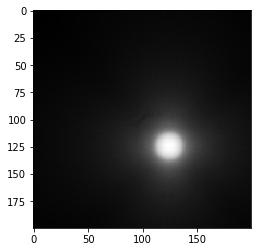

In [11]:
# image = rgb2gray(io.imread("pictures/image_out.jpg", multichanel = False))
# ds.save_as("dicom/czary_mary.DCM")
ds = pydicom.dcmread("dicom/Jakub Kowalski.DCM")

image = rgb2gray(ds.pixel_array)
print("Image to process:")
print(ds.PatientName)
print(ds.StudyDescription)
print(ds.PatientID)
plt.imshow(image, 'gray')
plt.show()

